In [1]:
import glob
from collections import defaultdict
import pandas as pd
import os.path as op
import math
import os 
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import sqlite3
import sqlalchemy

def safe_makedir(dname):
    """
    Make a directory if it doesn't exist, handling concurrent race conditions.
    """
    if not dname:
        return dname
    num_tries = 0
    max_tries = 5
    while not os.path.exists(dname):
        try:
            os.makedirs(dname)
        except OSError:
            if num_tries > max_tries:
                raise
            num_tries += 1
            time.sleep(2)
    return dname

# import my custom functions
sys.path.insert(0, '/home/jmunson-mcgee/')
from JMM_functions import *

pd.set_option("display.max_rows", 6)

outdir='/mnt/scgc/simon/microg2p/Melody/BLM1/Analyses/SSU_recruitment/'
safe_make_dir(outdir)
os.chdir(outdir)

images='/mnt/scgc/simon/microg2p/Melody/BLM1/images/'
safe_make_dir(images)
    
matplotlib.__version__



Folder already exists
Folder already exists


'3.3.3'

In [2]:
coverm_file='/mnt/scgc/simon/microg2p/Melody/BLM1/Analyses/SSU_recruitment/BLM1_16S_recruitment_reads_per_base_reads.tsv'
GORG_file='/mnt/scgc/simon/microg2p/Melody/BLM1/Analyses/RNA_GORG_recruit/Summary_files/cDNA7-A01_joined_annotated_RNA_GORG_results.csv'
SAG_file='/mnt/scgc/simon/microg2p/Melody/BLM1/Data/BLM1_Qc_MELODY_210625_VH00511_17_AAAG2WYHV_assembly_stats.csv'
Sample_file='/mnt/scgc/simon/microg2p/Melody/BLM1/Data/BLM1_InfoforMetatranscriptomes_11212022.csv'

gene_file='/mnt/scgc/simon/microg2p/Melody/BLM1/Analyses/mmseqs2/BLM1_SAG_names.txt'


In [3]:
tmp=pd.read_csv(Sample_file)
tmp

,Sample Type,Plate,cDNA Library,Volume Filtered for Metatranscriptome (L),Cells / mL,Qubit of MTST5 after 1:5 dilution (ug/ml),MTST5_concentration_of_added_sample ng/ul,Volume MTST5 added using 1:500 diluted standard (uL),ng_MTST5_added,copies_MTST5_added,Qubit of MTST6 after 1:5 dilution (ug/ml),MTST6_concentration_of_added_sample_ng/ul,Volume MTST6 added using 1:500 diluted standard (uL),ng_MTST6_added,copies_MTST6_added
0,Manifold SYBR,294,cDNA7,7.30,769,0.161,0.00161,6.211180,0.01,2267166,0.137,0.00137,7.299270,0.01,2313399
1,Manifold RSG,296/297,cDNA7,7.30,690,0.161,0.00161,6.211180,0.01,2267166,0.137,0.00137,7.299270,0.01,2313399
2,Acetate RSG,301,cDNA2,2.70,933,0.304,0.00304,3.289474,0.01,2267166,0.245,0.00245,4.081633,0.01,2313399
3,CO RSG,302,cDNA3,4.13,332,0.304,0.00304,3.289474,0.01,2267166,0.245,0.00245,4.081633,0.01,2313399
4,H2 RSG,307,cDNA4,3.94,748,0.304,0.00304,3.289474,0.01,2267166,0.245,0.00245,4.081633,0.01,2313399
5,No amend RSG,304,cDNA1,2.25,464,0.304,0.00304,3.289474,0.01,2267166,0.245,0.00245,4.081633,0.01,2313399


In [4]:
### Define variables to be used
volume=7300
cells_per_ml=769

MTST_num=22671660+23133998 # number of copies added of MTST5 and MTST6



DF_coverm=pd.read_csv(coverm_file, sep='\t')
DF_coverm['SAG']=DF_coverm['Genome'].str[:10]
cols=['well', 'Domain', 'phyla', 'class', 'order', 'family', 'genus', 'species', 'GTDB_classification']

# import the SAG data and generate a DF with the relative abundance at the family and genus level
DF_SAG=pd.read_csv(SAG_file, usecols=cols)
DF_Syto9=DF_SAG[DF_SAG['well'].str.contains('AM-294')]


DF_ord_abun=DF_Syto9.groupby('order', as_index=False)['well'].count()
DF_ord_abun=DF_ord_abun.rename(columns={'well':'number_of_cells'})
DF_ord_abun['relative_abundance']=DF_ord_abun['number_of_cells']/DF_ord_abun['number_of_cells'].sum()
DF_ord_abun['cells_per_sample']=DF_ord_abun['relative_abundance']*(volume*cells_per_ml)


Counter(DF_SAG['order'])


DF_MTST=DF_coverm[DF_coverm['Genome']=='MTST_Standards']
DF_transcripts=pd.DataFrame()
DF_transcripts['SAG']=DF_coverm['SAG']

# Just hard code all of my convesion factors. They are all slightly different based on the number of 
# reads that recruited to MTST in each sample
Conversion=MTST_num/DF_MTST.at[109, 'cDNA1-A01_joined.fastq.gz Reads per base']
DF_transcripts['No_amendment_transcripts']=DF_coverm['cDNA1-A01_joined.fastq.gz Reads per base']*Conversion

Conversion=MTST_num/DF_MTST.at[109, 'cDNA2-A01_joined.fastq.gz Reads per base']
DF_transcripts['Acetate_transcripts']=DF_coverm['cDNA2-A01_joined.fastq.gz Reads per base']*Conversion

Conversion=MTST_num/DF_MTST.at[109, 'cDNA3-A01_joined.fastq.gz Reads per base']
DF_transcripts['CO_transcripts']=DF_coverm['cDNA3-A01_joined.fastq.gz Reads per base']*Conversion

Conversion=MTST_num/DF_MTST.at[109, 'cDNA4-A01_joined.fastq.gz Reads per base']
DF_transcripts['H2_transcripts']=DF_coverm['cDNA4-A01_joined.fastq.gz Reads per base']*Conversion

Conversion=MTST_num/DF_MTST.at[109, 'cDNA7-A01_joined.fastq.gz Reads per base']
DF_transcripts['Manifold_transcripts']=DF_coverm['cDNA7-A01_joined.fastq.gz Reads per base']*Conversion

DF_transcripts=DF_transcripts.merge(DF_SAG, left_on='SAG', right_on='well', how='left')

DF_transcripts.to_csv(os.path.join(outdir, '16S_transcripts_per_sample.csv'))
DF_transcripts

,SAG,No_amendment_transcripts,Acetate_transcripts,CO_transcripts,H2_transcripts,Manifold_transcripts,well,Domain,phyla,class,order,family,genus,species,GTDB_classification
0,AM-294-B02,4.281157e+04,1.010403e+05,8.387343e+03,2.188977e+05,6.079935e+05,AM-294-B02,d__Archaea,p__Hadarchaeota,c__Hadarchaeia,o__Hadarchaeales,f__,g__,s__,d__Archaea;p__Hadarchaeota;c__Hadarchaeia;o__H...
1,AM-294-B06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.122365e+03,AM-294-B06,d__Bacteria,p__Bipolaricaulota,c__Bipolaricaulia,o__Bipolaricaulales,f__Bipolaricaulaceae,g__,s__,d__Bacteria;p__Bipolaricaulota;c__Bipolaricaul...
2,AM-294-B10,3.929579e+05,7.704249e+05,3.456217e+05,1.889672e+06,3.374555e+05,AM-294-B10,d__Bacteria,p__Nitrospirota,c__Thermodesulfovibrionia,o__Thermodesulfovibrionales,f__,g__,s__,d__Bacteria;p__Nitrospirota;c__Thermodesulfovi...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,AM-307-E17,4.190447e+04,1.008749e+05,1.061802e+04,2.197063e+05,6.115550e+05,AM-307-E17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,AM-307-N06,1.303581e+05,8.103763e+04,2.742610e+05,5.971710e+05,3.890396e+06,AM-307-N06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,MTST_Stand,4.580566e+07,4.580566e+07,4.580566e+07,4.580566e+07,4.580566e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
DF_MTST

,Genome,cDNA1-A01_joined.fastq.gz Reads per base,cDNA2-A01_joined.fastq.gz Reads per base,cDNA3-A01_joined.fastq.gz Reads per base,cDNA4-A01_joined.fastq.gz Reads per base,cDNA6-A01_joined.fastq.gz Reads per base,cDNA7-A01_joined.fastq.gz Reads per base,cDNA9-A01_joined.fastq.gz Reads per base,SAG
109,MTST_Standards,1965.144,769.63904,356.7482,905.3705,80.10579,1036.789,101.96889,MTST_Stand


In [5]:
DF_manifold=DF_transcripts.groupby('order', as_index=False)['Manifold_transcripts'].sum()
DF_manifold=DF_manifold.merge(DF_ord_abun, on='order', how='outer')
DF_manifold['transcripts_per_cell']=DF_manifold['Manifold_transcripts']/DF_manifold['cells_per_sample']

# I need to get rid of the unknown cells because this is going to be articically low. 
# eg. I can only recruit to 16S sequences that I have not all the 16S sequences that are present in the sample
DF_manifold=DF_manifold[DF_manifold['order']!='o__']


DF_manifold.to_csv(os.path.join(outdir, 'Manifold_16S_transcripts_per_cell.csv'))
DF_manifold

,order,Manifold_transcripts,number_of_cells,relative_abundance,cells_per_sample,transcripts_per_cell
1,o__Ammonifexales,1.335426e+08,47.0,0.340580,1.911912e+06,69.847636
2,o__B26-1,2.981690e+06,4.0,0.028986,1.627159e+05,18.324509
3,o__BSN033,5.101111e+06,1.0,0.007246,4.067899e+04,125.399170
...,...,...,...,...,...,...
16,o__Bryobacterales,NaN,1.0,0.007246,4.067899e+04,NaN
17,o__CSP1-3,NaN,2.0,0.014493,8.135797e+04,NaN
18,o__Nitrososphaerales,NaN,1.0,0.007246,4.067899e+04,NaN


In [6]:
cols=['No_amendment_transcripts', 'Acetate_transcripts', 'CO_transcripts', 'H2_transcripts', 'Manifold_transcripts']

DF_transcripts_per_cell=pd.DataFrame()

libraries={'cDNA1-A01':'No_amendment_transcripts', 'cDNA2-A01':'Acetate_transcripts', 'cDNA3-A01':'CO_transcripts', 
         'cDNA4-A01':'H2_transcripts', 'cDNA7-A01':'Manifold_transcripts'}

volumes={'No_amendment_transcripts':2250, 'Acetate_transcripts':2700, 'CO_transcripts':4130, 
         'H2_transcripts':3940, 'Manifold_transcripts':7300}

cells_per_ml={'No_amendment_transcripts':769, 'Acetate_transcripts':769, 'CO_transcripts':769, 
              'H2_transcripts':769, 'Manifold_transcripts':769}

for col in cols:
    tdf=DF_transcripts.groupby('order', as_index=False)[col].sum()
    tdf=tdf.rename(columns={col:'number_of_transcripts'})

    # use the dictionaries above to calculate the number of cells for each lineage 
    volume=volumes[col]
    cells=cells_per_ml[col] 
    DF_ord_abun['cells_per_sample']=DF_ord_abun['relative_abundance']*(volume*cells)
    
    tdf=tdf.merge(DF_ord_abun, on='order', how='outer')
    tdf['sample']=col
    tdf['transcripts_per_cell']=tdf['number_of_transcripts']/tdf['cells_per_sample']

    # I need to get rid of the unknown cells because this is going to be articically low. 
    # eg. I can only recruit to 16S sequences that I have not all the 16S sequences that are present in the sample
    tdf=tdf[tdf['order']!='o__']
    
    DF_transcripts_per_cell=pd.concat([DF_transcripts_per_cell, tdf])
DF_transcripts_per_cell.to_csv(os.path.join(outdir, '16S_transcripts_per_cell_per_sample.csv'))
DF_transcripts_per_cell

,order,number_of_transcripts,number_of_cells,relative_abundance,cells_per_sample,sample,transcripts_per_cell
1,o__Ammonifexales,9.701635e+06,47.0,0.340580,589288.043478,No_amendment_transcripts,16.463316
2,o__B26-1,4.888514e+05,4.0,0.028986,50152.173913,No_amendment_transcripts,9.747362
3,o__BSN033,1.582583e+06,1.0,0.007246,12538.043478,No_amendment_transcripts,126.222506
...,...,...,...,...,...,...,...
16,o__Bryobacterales,NaN,1.0,0.007246,40678.985507,Manifold_transcripts,NaN
17,o__CSP1-3,NaN,2.0,0.014493,81357.971014,Manifold_transcripts,NaN
18,o__Nitrososphaerales,NaN,1.0,0.007246,40678.985507,Manifold_transcripts,NaN


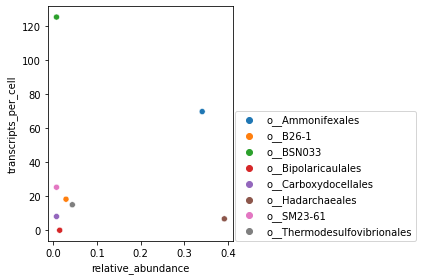

In [7]:
DF_manifold=DF_manifold[DF_manifold['transcripts_per_cell']>0]
sns.scatterplot(data=DF_manifold, x='relative_abundance', y='transcripts_per_cell', hue='order', cmap='viridis')
plt.legend(loc=(1.01, 0.0))
plt.tight_layout()
plt.savefig(os.path.join(images, '16S_transcripts_vs_abundance.pdf'))

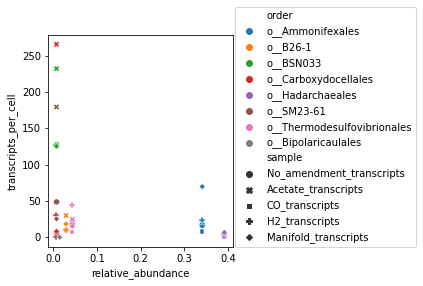

In [8]:
DF_transcripts_per_cell=DF_transcripts_per_cell[DF_transcripts_per_cell['transcripts_per_cell']>0]
sns.scatterplot(data=DF_transcripts_per_cell, x='relative_abundance', y='transcripts_per_cell', hue='order', cmap='viridis', style='sample')
plt.legend(loc=(1.01, 0.0))
plt.tight_layout()
plt.savefig(os.path.join(images, '16S_transcripts_per_sample_vs_abundance.pdf'))



In [9]:
DF_manifold['transcripts_per_cell'].min()

0.0752521828217802

I have to think aobut the best way to do an analysis for Melodie's samples. I think that I should go ahead and calcualte the number of transcripts per cell for every single classificaiton that I have and then I can manually go through and combine some of them if I want to. eg
Bacteria; Firmicutes_B; Desulfotomaculia; Ammonifexales; Desulforudaceae; Desulforudis; Desulforudis audaxviator;
Bacteria; Firmicutes_B; Desulfotomaculia; Ammonifexales; Desulforudaceae; Desulforudis; NA;
Bacteria; Firmicutes_B; Desulfotomaculia; Ammonifexales; Desulforudaceae; NA; NA;!

are probably all part of the first species. Since there are so few total classifications Melody and I can go through them manually and combine taxonomies if necessary.

### mRNA files

In [10]:
outdir='/mnt/scgc/simon/microg2p/Melody/BLM1/Analyses/RNA_GORG_recruit/Summary_files'
safe_make_dir(outdir)

Folder already exists


In [11]:
# read in the gene file and modify it so that I have the length and gene name exactly the same as in the GORG file

DF_genes=pd.read_csv(gene_file, names=['Name'])
DF_genes[['gene', 'tmp']]=DF_genes['Name'].str.rsplit('_',1, expand=True)
DF_genes[['SAG', 'start', 'end']]=DF_genes['Name'].str.split(';', expand=True)
DF_genes[['end', 'tax_id']]=DF_genes['end'].str.split('_', expand=True)
DF_genes[["start", "end"]] = DF_genes[["start", "end"]].apply(pd.to_numeric)
DF_genes['length']=abs(DF_genes['start']-DF_genes['end'])
DF_genes['gene']=DF_genes['gene'].str[1:]
DF_genes['gene']=DF_genes['gene'].str[:2] + '-' + DF_genes['gene'].str[2:5] + '-'+DF_genes['gene'].str[5:]

DF_genes=DF_genes.drop(columns=['SAG', 'start', 'end', 'tax_id', 'Name', 'tmp'])

# read in the GORG file
DF_GORG=pd.read_csv(GORG_file, index_col=0)

DF_GORG=DF_GORG.merge(DF_genes, left_on='gene_cluster_rep', right_on='gene', how='left')
DF_GORG['reads_per_base']=DF_GORG['number_of_reads']/DF_GORG['length']

# make sure my conversion factor is still correct
Conversion=MTST_num/DF_MTST.at[109, 'cDNA7-A01_joined.fastq.gz Reads per base']
DF_GORG['number_of_transcripts']=DF_GORG['reads_per_base']*Conversion

# split the taxonomic lineage into levels
DF_GORG[['domain', 'phyla', 'class', 'order', 'family', 'genera', 'species', 'strain']]=DF_GORG['taxonomic_lineage'].str.split(';', expand=True)
DF_GORG['order']=DF_GORG['order'].str.strip()

# define variables
volume=7300
cells=769
# define relative abundance df again
DF_ord_abun=DF_Syto9.groupby('order', as_index=False)['well'].count()
DF_ord_abun=DF_ord_abun.rename(columns={'well':'number_of_cells'})
DF_ord_abun['relative_abundance']=DF_ord_abun['number_of_cells']/DF_ord_abun['number_of_cells'].sum()
DF_ord_abun['cells_per_sample']=DF_ord_abun['relative_abundance']*(volume*cells)

DF_ord_abun['order']=DF_ord_abun['order'].str[3:]
DF_ord_abun['order']=DF_ord_abun['order'].str.strip()

DF_GORG=DF_GORG.merge(DF_ord_abun, on='order', how='left')
DF_GORG['transcripts_per_cell']=DF_GORG['number_of_transcripts']/DF_GORG['cells_per_sample']

# DF_order_reads=DF_GORG.groupby('order', as_index=False)

DF_GORG.to_csv(os.path.join(outdir, 'Manifold__mRNA_transcripts_per_cell.csv'))



In [12]:
DF_mRNA=DF_GORG.groupby('order',as_index=False)['transcripts_per_cell'].sum()
DF_mRNA=DF_mRNA.rename(columns={'transcripts_per_cell':'total_transcripts_per_cell'})
DF_mRNA.to_csv(os.path.join(outdir, 'Manifold_Total_mRNA_transcripts_per_cell.csv'))
DF_mRNA['order'].fillna(value='Other')
DF_mRNA['total_transcripts_per_cell'].max()

36.732226548076774

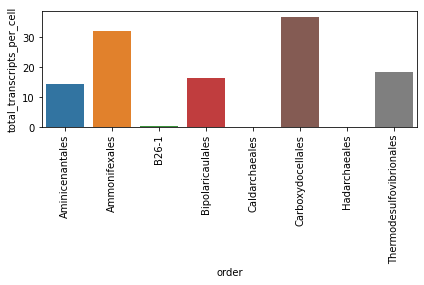

In [13]:
DF_mRNA=DF_mRNA[DF_mRNA['total_transcripts_per_cell']>0]
sns.barplot(data=DF_mRNA, x='order', y='total_transcripts_per_cell')
plt.xticks(rotation = 90)
plt.tight_layout()
plt.savefig(os.path.join(images, 'Manifold_total_mRNA_transcripts_per_cell.pdf'))

In [14]:
# I should probably loop the above and do this for every sample just like I did for the 16S samples previously.

fam_files=glob.glob('/mnt/scgc/simon/microg2p/Melody/BLM1/Analyses/RNA_GORG_recruit/Summary_files/cDNA*-A01_joined_annotated_RNA_GORG_results.csv')

fdf=pd.DataFrame()

for file in fam_files:
    base=os.path.basename(file)
    sample=base[:9]
    print(sample)
    col=sample+'_joined.fastq.gz Reads per base'
    
    DF_GORG=pd.read_csv(file, index_col=0)

    DF_GORG=DF_GORG.merge(DF_genes, left_on='gene_cluster_rep', right_on='gene', how='left')
    DF_GORG['reads_per_base']=DF_GORG['number_of_reads']/DF_GORG['length']

    # make sure my conversion factor is still correct
    Conversion=MTST_num/DF_MTST.at[109, col]
    DF_GORG['number_of_transcripts']=DF_GORG['reads_per_base']*Conversion

    # split the taxonomic lineage into levels
    DF_GORG[['domain', 'phyla', 'class', 'order', 'family', 'genera', 'species', 'strain']]=DF_GORG['taxonomic_lineage'].str.split(';', expand=True)
    DF_GORG['order']=DF_GORG['order'].str.strip()
    
    # extract the volume and number of cells again
    amend=libraries[sample]
    volume=volumes[amend]
    cells=cells_per_ml[amend]
    print(volume)
  
    # define relative abundance df again
    DF_ord_abun=DF_Syto9.groupby('order', as_index=False)['well'].count()
    DF_ord_abun=DF_ord_abun.rename(columns={'well':'number_of_cells'})
    DF_ord_abun['relative_abundance']=DF_ord_abun['number_of_cells']/DF_ord_abun['number_of_cells'].sum()
    DF_ord_abun['cells_per_sample']=DF_ord_abun['relative_abundance']*(volume*cells)
    DF_ord_abun['order']=DF_ord_abun['order'].str[3:]
    DF_ord_abun['order']=DF_ord_abun['order'].str.strip()
    
    DF_GORG=DF_GORG.merge(DF_ord_abun, on='order', how='left')
    DF_GORG['transcripts_per_cell']=DF_GORG['number_of_transcripts']/DF_GORG['cells_per_sample']
    
    # sum up all of the transcripts for each order
    DF_mRNA=DF_GORG.groupby('order',as_index=False)['transcripts_per_cell'].sum()
    DF_mRNA=DF_mRNA.rename(columns={'transcripts_per_cell':'total_mRNA_transcripts_per_cell'})
#     DF_mRNA=DF_mRNA[DF_mRNA['total_transcripts_per_cell']>0]
    # create file_name and save csv
    out_name=amend+'mRNA_transcripts_per_cell.csv'
    DF_mRNA.to_csv(os.path.join(outdir, out_name))
    
    
    tdf=DF_mRNA[['total_mRNA_transcripts_per_cell', 'order']].copy()
    tdf['sample']=amend
    
    fdf=pd.concat([fdf, tdf])
    
fdf

cDNA4-A01
3940
cDNA2-A01
2700
cDNA3-A01
4130
cDNA7-A01
7300
cDNA1-A01
2250


,total_mRNA_transcripts_per_cell,order,sample
0,6.576488,Ammonifexales,H2_transcripts
1,0.003705,B26-1,H2_transcripts
2,9.381519,Bipolaricaulales,H2_transcripts
...,...,...,...
6,0.000000,NA,No_amendment_transcripts
7,0.000000,RBG-16-55-9,No_amendment_transcripts
8,31.014635,Thermodesulfovibrionales,No_amendment_transcripts


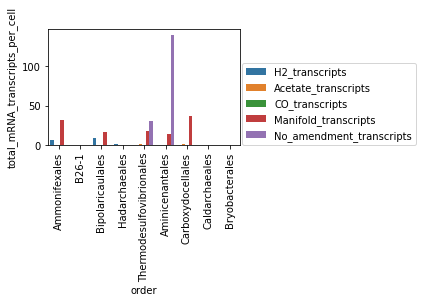

In [15]:
fdf=fdf[fdf['total_mRNA_transcripts_per_cell']>0]
sns.barplot(data=fdf, x='order', y='total_mRNA_transcripts_per_cell', hue='sample')
plt.xticks(rotation = 90)
plt.legend(loc=(1.01, 0.0))
plt.tight_layout()
plt.savefig(os.path.join(images, 'total_mRNA_transcripts_per_cell_per_sample.pdf'))

In [16]:
print(fdf.total_mRNA_transcripts_per_cell.mean())
print(fdf.total_mRNA_transcripts_per_cell.min())
print(fdf.total_mRNA_transcripts_per_cell.max())

fdf#.reset_index()

12.475679433607208
0.00016042808646770992
139.8721399616169


,total_mRNA_transcripts_per_cell,order,sample
0,6.576488,Ammonifexales,H2_transcripts
1,0.003705,B26-1,H2_transcripts
2,9.381519,Bipolaricaulales,H2_transcripts
...,...,...,...
3,0.001723,Carboxydocellales,No_amendment_transcripts
4,0.398639,Hadarchaeales,No_amendment_transcripts
8,31.014635,Thermodesulfovibrionales,No_amendment_transcripts


In [17]:
DF_transcripts_per_cell=DF_transcripts_per_cell.rename(columns={'transcripts_per_cell':'total_16S_transcripts_per_cell'})
DF_16S=DF_transcripts_per_cell[['order', 'sample', 'total_16S_transcripts_per_cell']].copy()
DF_16S['order']=DF_16S['order'].str[3:]
DF_16S

,order,sample,total_16S_transcripts_per_cell
1,Ammonifexales,No_amendment_transcripts,16.463316
2,B26-1,No_amendment_transcripts,9.747362
3,BSN033,No_amendment_transcripts,126.222506
...,...,...,...
7,Hadarchaeales,Manifold_transcripts,6.785216
13,SM23-61,Manifold_transcripts,25.355075
14,Thermodesulfovibrionales,Manifold_transcripts,15.066878


In [18]:
DF_RNA_transcripts_per_cell=fdf.merge(DF_16S, on=['order', 'sample'], how='outer')
DF_RNA_transcripts_per_cell.to_csv(os.path.join(outdir, 'total_RNA_transcripts_per_cell.csv'))
# DF_RNA_transcripts_per_cell.dropna(how='any', inplace=True)
DF_RNA_transcripts_per_cell

,total_mRNA_transcripts_per_cell,order,sample,total_16S_transcripts_per_cell
0,6.576488,Ammonifexales,H2_transcripts,23.986344
1,0.003705,B26-1,H2_transcripts,10.018194
2,9.381519,Bipolaricaulales,H2_transcripts,NaN
...,...,...,...,...
37,NaN,SM23-61,H2_transcripts,0.455840
38,NaN,BSN033,Manifold_transcripts,125.399170
39,NaN,SM23-61,Manifold_transcripts,25.355075


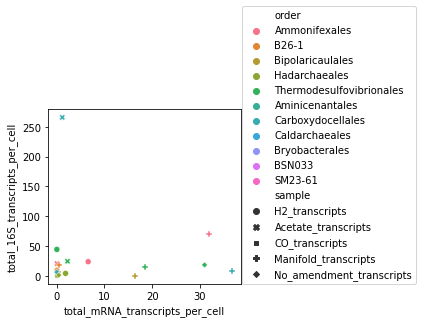

In [19]:
sns.scatterplot(data=DF_RNA_transcripts_per_cell, x='total_mRNA_transcripts_per_cell', 
               y='total_16S_transcripts_per_cell', hue='order', style='sample')
plt.legend(loc=(1.01, 0.0))
plt.tight_layout()